In [1]:
from pyDOE import lhs
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math 
from torch.autograd import grad

In [2]:
class Schrodinger_Boundary(Dataset):
    def __init__(self):  
        samples = 50
        samples_half = math.floor(samples/2)
        self.t = torch.tensor(np.squeeze(lhs(1,samples=samples_half)*math.pi/2), requires_grad=True).float().to(device)
        return
    def __getitem__(self,idx):
        return self.t[idx]
    def __len__(self):
        return len(self.t)
    def getall(self):
        return self.t
    
class Schrodinger_Initial(Dataset):
    def __init__(self):            
        h_func = lambda x : 2 * (1/torch.cosh(x))
        samples = 50
        self.x = torch.tensor((lhs(1,samples=samples)*10 - 5), requires_grad=True).float().to(device)
        print(self.x.shape)
        self.h = torch.squeeze(torch.stack((
            torch.tensor(h_func(self.x)).float().to(device),
            torch.zeros((len(self.x),1)).to(device)
        ),1))
        return
    def __getitem__(self,idx):
        return self.x[idx], self.h[idx]
    def __len__(self):
        return len(self.x)
    def getall(self):
        return self.x,self.h

class Schrodinger(Dataset):
    def __init__(self): # returns x,t
        samples = 20000
        x = torch.tensor(lhs(1,samples=samples)*10 - 5,requires_grad=True).float().to(device)
        t = torch.tensor(lhs(1,samples=samples)*(math.pi/2),requires_grad=True).float().to(device)
        self.X = torch.squeeze(torch.dstack((x,t))).float()
        return 
    def __getitem__(self,idx):
        return self.X[idx]
    def __len__(self):
        return len(self.X)
    def getall(self):
        return self.X
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Torch utilizing dev",device)

boundary_ds = Schrodinger_Boundary()
initial_ds = Schrodinger_Initial()
schrodinger_ds = Schrodinger()

schrodinger_dl = DataLoader(schrodinger_ds, batch_size=4096, shuffle=True)

Torch utilizing dev cuda:0
torch.Size([50, 1])


C:\Users\azkama\AppData\Local\Temp\ipykernel_16860\1651495912.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(h_func(self.x)).float().to(device),


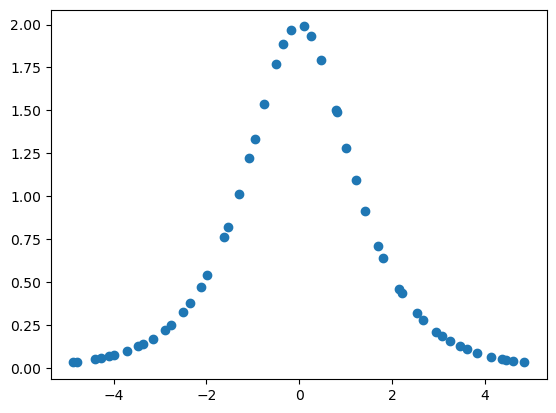

In [3]:
# Plot the initial condition
x_sample, h_sample = initial_ds.getall()

plt.scatter(x_sample.cpu().detach().numpy(), h_sample[:, 0].cpu().detach().numpy())

In [14]:
h_sample[:, 0].shape

torch.Size([50])

In [9]:
x_sample.shape

torch.Size([50, 1])

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()        
        # NN layers
        self.dense1 = nn.Linear(2,100).to(device)
        torch.nn.init.xavier_uniform_(self.dense1.weight)
        self.dense2 = nn.Linear(100,100).to(device)
        torch.nn.init.xavier_uniform_(self.dense2.weight)
        self.dense3 = nn.Linear(100,100).to(device)
        torch.nn.init.xavier_uniform_(self.dense3.weight)
        self.dense4 = nn.Linear(100,100).to(device)
        torch.nn.init.xavier_uniform_(self.dense4.weight)
        self.dense5 = nn.Linear(100,100).to(device)
        torch.nn.init.xavier_uniform_(self.dense5.weight)
        self.dense6 = nn.Linear(100,2).to(device)
        torch.nn.init.xavier_uniform_(self.dense6.weight)
        self.optimizer = optim.Adam(self.parameters(), lr=0.00025)
        pass

    def forward(self,X):
        x = self.dense1(X)
        x = torch.tanh(x)      
        x = self.dense2(x)
        x = torch.tanh(x)     
        x = self.dense3(x)
        x = torch.tanh(x)      
        x = self.dense4(x)
        x = torch.tanh(x)     
        x = self.dense5(x)
        x = torch.tanh(x)     
        x = self.dense6(x)
        return x
    
    def h(self, x, t):
        X = torch.cat((x,t),1).float().to(device)
        return self.forward(X)

    def norm(self, real, compl):
      return torch.sqrt((real**2) + (compl**2))

    def loss(self):
        
        # Initial Condition: h(x,0) = 2sech(x)
        X_0,H_0 = initial_ds.getall()
        zeros = torch.zeros((len(X_0),1)).float().to(device)

        h = self.h(X_0,zeros)
        h_r = h[:,0]
        h_c = h[:,1]
         
        J_0 = torch.mean((H_0 - h)**2)

        # Function Condition ih_t + 0.5h_xx + h(|h|**2) = 0
        X = schrodinger_ds.getall()
        x = torch.unsqueeze(X[:,0], 1)
        t = torch.unsqueeze(X[:,1], 1)

        _h = self.h(x,t)

        hf_r = torch.unsqueeze(_h[:,0],1)
        hf_c = torch.unsqueeze(_h[:,1],1)
        
        h_fx_r = grad(outputs=hf_r, inputs=x, grad_outputs=torch.ones_like(hf_r), create_graph=True)[0]
        h_fxx_r = grad(outputs=h_fx_r, inputs=x, grad_outputs=torch.ones_like(h_fx_r), create_graph=True)[0]
        h_ft_r = grad(outputs=hf_r, inputs=t, grad_outputs=torch.ones_like(hf_r), create_graph=True)[0]
        
        h_fx_c = grad(outputs=hf_c, inputs=x, grad_outputs=torch.ones_like(hf_c), create_graph=True)[0]
        h_fxx_c = grad(outputs=h_fx_c, inputs=x, grad_outputs=torch.ones_like(h_fx_c), create_graph=True)[0]
        h_ft_c = grad(outputs=hf_c, inputs=t, grad_outputs=torch.ones_like(hf_c), create_graph=True)[0]

        f_r = (h_ft_r) + (0.5 * h_fxx_c) + (((hf_r**2)+(hf_c**2))*hf_c)   
        f_c = (h_ft_c) - (0.5 * h_fxx_r) - (((hf_r**2)+(hf_c**2))*hf_r) 
        
        J_f = torch.mean(self.norm(f_r,f_c)**2)

        # # Boundary conditions
        tb = torch.unsqueeze(boundary_ds.getall(),1)
        fives = torch.ones((len(tb),1), requires_grad=True).to(device)*5.

        hp = self.h(fives,tb)
        hn = self.h(-fives,tb)

        hp_r = hp[:,0]
        hn_r = hn[:,0]
        hp_c = hp[:,1]
        hn_c = hn[:,1]

        hp_r_x = grad(outputs=hp_r, inputs=fives, grad_outputs=torch.ones_like(hp_r), create_graph=True)[0]
        hp_c_x = grad(outputs=hp_c, inputs=fives, grad_outputs=torch.ones_like(hp_c), create_graph=True)[0]

        hn_r_x = grad(outputs=hn_r, inputs=fives, grad_outputs=torch.ones_like(hn_r), create_graph=True)[0]
        hn_c_x = grad(outputs=hn_c, inputs=fives, grad_outputs=torch.ones_like(hn_c), create_graph=True)[0]
        
        h_r_err = torch.unsqueeze(hp_r - hn_r,1)
        h_c_err = torch.unsqueeze(hp_c - hn_c,1)

        h_xr_err = hp_r_x - hn_r_x
        h_xc_err = hp_c_x - hn_c_x

        h_err = (h_r_err**2) + (h_c_err**2)
        h_x_err = (h_xr_err**2) + (h_xc_err**2)

        J_B = torch.mean( (h_err**2) + (h_x_err**2) )

        return J_0 + J_B + J_f 
        
    def train(self,epochs,display_every_n_epochs):
        history = []
        epoch_hist = []
        for i in range(0, epochs):
            self.zero_grad()
            loss = self.loss()
            loss.backward()
            self.optimizer.step()
            if(i % display_every_n_epochs == 0):
                print("Epoch", i, "~ Train Loss" , loss.item())
                history.append(loss.item())
                epoch_hist.append(i)
        print("Final Loss: ", loss)
        return epoch_hist, history
    
_nn = PINN().to(device)
epochs,hist = _nn.train(epochs=20000,display_every_n_epochs=1000)

plt.plot(epochs,hist)
plt.xlabel("Epochs")
plt.ylabel("Sum of MSE Loss") 
plt.title("PINN Train Loss")
plt.show() 

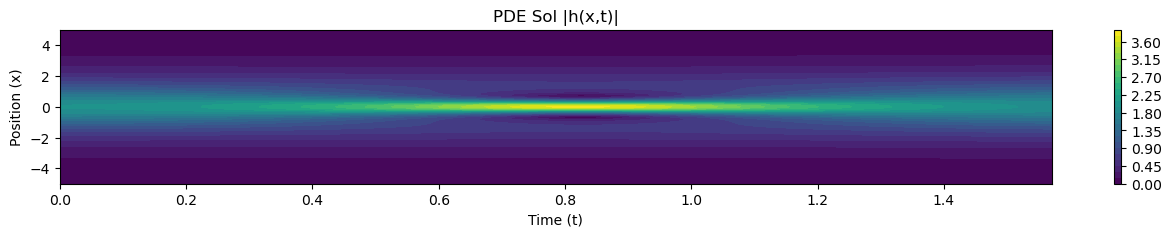

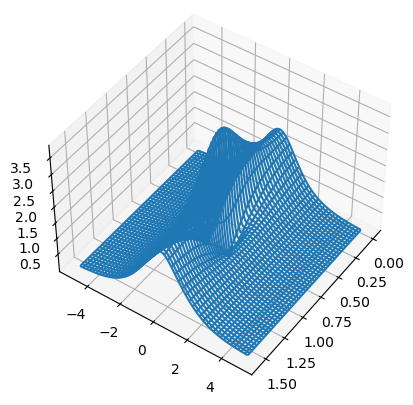

Text(0, 0.5, '|h(t,x)|')

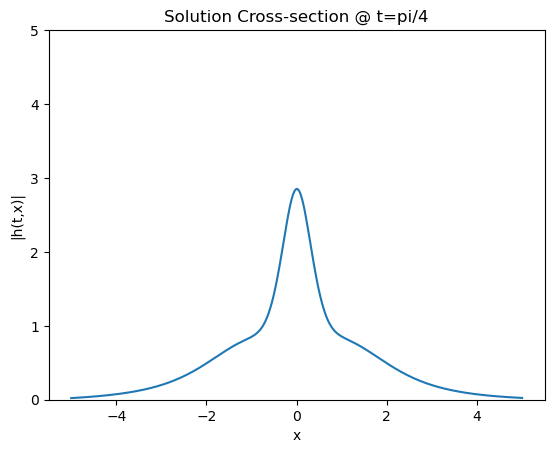

In [7]:
%matplotlib inline

x = np.linspace(-5,5,300)
t = np.linspace(0,math.pi/2,300)

X,T = np.meshgrid(x,t)

_X = torch.tensor(np.dstack((X,T))).float().to(device)

h_hat = _nn.forward(_X).to('cpu').detach().numpy()

h_norm = np.sqrt((h_hat[:,:,0] ** 2) + (h_hat[:,:,1] ** 2))

fig = plt.figure(figsize=(16, 2))
ax = plt.axes()

cf = ax.contourf(T,X,h_norm, 30)
plt.colorbar(cf)

plt.title('PDE Sol |h(x,t)|')
plt.ylabel("Position (x)")
plt.xlabel("Time (t)")
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_wireframe(T, X, h_norm, cmap='binary')
ax.view_init(45, 35)
plt.show()

x_slice = x[:]
h_slice = h_norm[100,:]

plt.ylim(0,5)

plt.plot(x_slice,h_slice)
plt.title('Solution Cross-section @ t=pi/4')
plt.xlabel('x')
plt.ylabel('|h(t,x)|')